In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [3]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


In [4]:
# Define local paths
csv_path = "pokemon.csv"  
image_dir = "images" 
df = pd.read_csv(csv_path)

In [5]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Type1'])
num_classes = len(label_encoder.classes_)
print(f"Classifying into {num_classes} types: {label_encoder.classes_}")

Classifying into 18 types: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']


In [6]:
# Step 4: Custom Dataset
class PokemonDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name = self.df.iloc[idx]['Name']
        label = self.df.iloc[idx]['label']
        img_path = os.path.join(self.image_dir, f"{name}.png")
        if os.path.exists(img_path):
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            return image, label

In [7]:
# Transforms
transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [8]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['Type1'], random_state=42)
train_dataset = PokemonDataset(train_df, image_dir, transform=transform)
test_dataset = PokemonDataset(test_df, image_dir, transform=transform)

In [9]:
# Filter out None entries (if any missing images)
train_dataset = [item for item in train_dataset if item[0] is not None]
test_dataset = [item for item in test_dataset if item[0] is not None]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# Step 5: Model - Use transfer learning with ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training function
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")


In [13]:
# Evaluate
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [14]:
# After train_model call, evaluate in more detail
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Specify labels to include all classes
print(classification_report(all_labels, all_preds, labels=range(num_classes), target_names=label_encoder.classes_))

              precision    recall  f1-score   support

         Bug       0.00      0.00      0.00        14
        Dark       0.00      0.00      0.00         6
      Dragon       0.00      0.00      0.00         5
    Electric       0.00      0.00      0.00         8
       Fairy       0.00      0.00      0.00         4
    Fighting       0.00      0.00      0.00         6
        Fire       0.00      0.00      0.00        11
      Flying       0.00      0.00      0.00         0
       Ghost       0.00      0.00      0.00         5
       Grass       0.00      0.00      0.00        16
      Ground       0.00      0.00      0.00         6
         Ice       0.00      0.00      0.00         5
      Normal       0.00      0.00      0.00        21
      Poison       0.05      1.00      0.09         7
     Psychic       0.00      0.00      0.00        11
        Rock       0.00      0.00      0.00         9
       Steel       0.00      0.00      0.00         5
       Water       0.00    

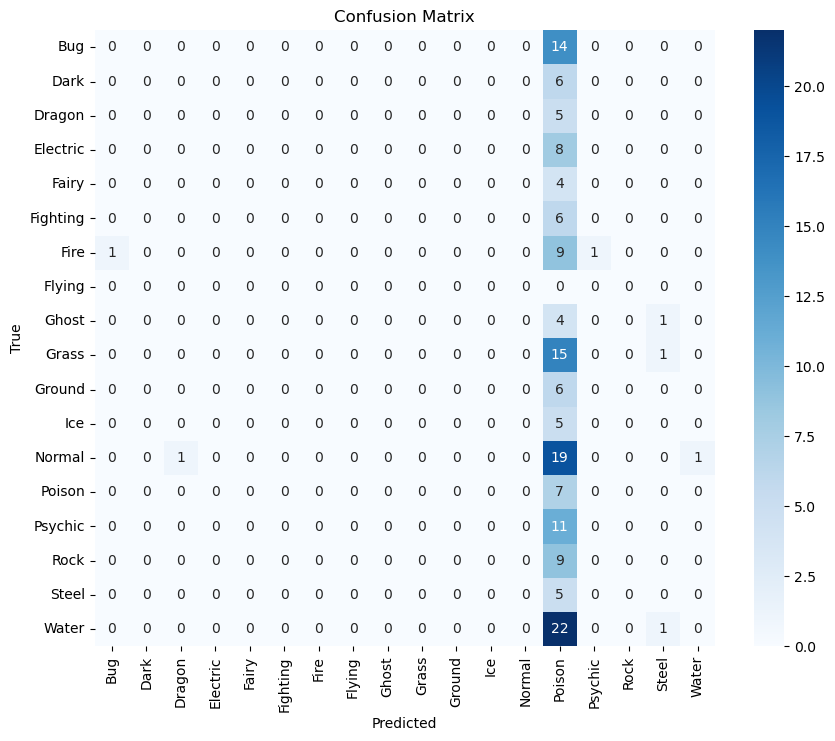

In [15]:
# Confusion matrix (optional visualization, also specifying labels)
cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [16]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.4f}")

Epoch 1/10 | Loss: 2.7429 | Accuracy: 0.2056
Epoch 2/10 | Loss: 2.1812 | Accuracy: 0.3431
Epoch 3/10 | Loss: 1.8023 | Accuracy: 0.4420
Epoch 4/10 | Loss: 1.5170 | Accuracy: 0.5286
Epoch 5/10 | Loss: 1.1428 | Accuracy: 0.6445
Epoch 6/10 | Loss: 0.7214 | Accuracy: 0.7821
Epoch 7/10 | Loss: 0.4639 | Accuracy: 0.8686
Epoch 8/10 | Loss: 0.3078 | Accuracy: 0.9227
Epoch 9/10 | Loss: 0.3726 | Accuracy: 0.9057
Epoch 10/10 | Loss: 0.2868 | Accuracy: 0.9104
